## Research Aim and Objectives

The aim of this study is to develop and evaluate a Rank-Based Bayesian Optimization (RBO) method for hyperparameter tuning when only rank information is available.

#### The Objectives will be to:

+ Propose a rank-based surrogate worth function that will guide the main function in attaining the optimal.
+ Implement an iterative optimization framework based on ranks.
+ Benchmark RBO against conventional methods (Optuna BO and Random Search) on a simulated AR model task.
+ Visualize and analyze the optimization dynamics over iterations.


In [1]:
#impoting libraries
import numpy as np
import random
import torch
import pandas as pd
import matplotlib.pyplot as plt
# Fix the seed:
seed = 13
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

## AR Dataset and Model

We generate a synthetic time series dataset using a linear trend autoregressive (AR) process.

$$
y_t = \gamma \cdot (y_{t-1} - \mu(t-1)) + \mu(t) + \epsilon_t
$$
where
$$
\mu(t) = a \cdot t + b
$$
and
$$
\epsilon_t \sim \mathcal{N}(0, \sigma^2).
$$


We develop an AR(k) model fitted via ridge regression (L2 regularization).

$$y_t = c+ \sum_i^k\phi_iy_{t-i} + \epsilon_t$$
$y_t$ is the data point, $\phi_i$ are the AR coefficients, $c$ is the intercept, and $\epsilon_t$ as in noise (zero mean Gaussian). The ridge regression coefficients are obtained by:
$$ \hat{\beta} = (X^TX + \lambda I)^{-1}X^Ty $$

where $\lambda$ is the weight decay that serves as L$2$ regularizer to control overfitting, and the matrix $X$ is determined by the length of the lag $k$.

In [2]:
def get_trajectory(trajectory_length, a, b, sigma, gamma):
    """
    Generate a single trajectory of length 2*trajectory_length from a linear trend autoregressive process.
    The first half will be for training, the second half for validation.
    
    Parameters:
    -----------
    trajectory_length : int
        Length of each half of the trajectory (train and validation)
    a : float
        Slope parameter of the linear trend
    b : float
        Intercept parameter of the linear trend
    sigma : float
        Standard deviation of the noise
    gamma : float
        Autoregressive coefficient
    
    Returns:
    --------
    train_data : np.array
        Training trajectory of shape (trajectory_length,)
    val_data : np.array
        Validation trajectory of shape (trajectory_length,)
    """
    # Calculate stationary standard deviation for initial point
    sigma_stationary = sigma / np.sqrt(1 - gamma**2)
    
    # Generate a trajectory of length 2*trajectory_length
    total_length = 2 * trajectory_length
    trajectory = np.zeros(total_length)
    
    # Generate mean trajectory
    y_mean = np.array([a*i + b for i in range(total_length)])
    
    # Generate initial point y[0]
    epsilon_0 = np.random.randn(1) * sigma_stationary
    trajectory[0] = b + epsilon_0.item()
    
    # Generate subsequent points
    for i in range(1, total_length):
        epsilon = np.random.randn(1) * sigma
        trajectory[i] = (gamma * (trajectory[i-1] - y_mean[i-1]) + y_mean[i] + epsilon).item()
    
    # Split into training and validation
    train_data = trajectory[:trajectory_length]
    val_data = trajectory[trajectory_length:]
    
    return train_data, val_data

class AutoregressiveModel:
    """
    Linear autoregressive model AR(k) with regularization.
    """
    def __init__(self, coefficients, intercept, sigma):
        """
        Initialize the model with fitted coefficients and intercept.
        
        Parameters:
        -----------
        coefficients : np.ndarray
            AR coefficients of shape (k,)
        intercept : float
            Intercept term
        """
        self.coefficients = coefficients
        self.intercept = intercept
        self.sigma = sigma
        self.k = len(coefficients)
    
    def sample(self, initial, n, n_steps):
        """
        Sample future trajectories given initial values.
        
        Parameters:
        -----------
        initial : np.ndarray
            Initial values of shape (k,) where k is the AR order
        n : int
            Number of trajectories to sample (batch size)
        n_steps : int
            Number of steps to predict ahead
            
        Returns:
        --------
        np.array
            Sampled trajectories of shape (n, n_steps)
        """
        if len(initial) < self.k:
            raise ValueError(f"Initial sequence must have at least {self.k} elements")
        
        # Use the last p values as the starting point
        initial = initial[-self.k:]
        
        # Initialize the samples tensor
        samples = np.zeros((n, n_steps))
        
        # Initialize history for each batch
        history = np.tile(initial, (n, 1))
        
        # Generate samples
        for t in range(n_steps):
            # Calculate the deterministic part (AR prediction)
            pred = self.intercept + np.sum(self.coefficients * history[:, :self.k], axis=1)
            
            # Add noise
            noise = np.random.normal(0, 1, size=n)
            samples[:, t] = pred + self.sigma*noise
            
            # Update history (shift and add new prediction)
            if self.k > 1:
                history = np.hstack((samples[:, t].reshape(-1, 1), history[:, :-1]))
            else:
                history = samples[:, t].reshape(-1, 1)
        
        return samples
    
    def predict_time_of_first_crossing(self, initial, n, n_steps, threshold):
        """
        Predict the expected time of first crossing of a threshold.
        
        Parameters:
        -----------
        initial : np.ndarray
            Initial values of shape (k,)
        n : int
            Number of Monte Carlo simulations
        n_steps : int
            Maximum number of steps to look ahead
        threshold : float
            Threshold value to cross
            
        Returns:
        --------
        float
            Expected time of first crossing
        """
        # Sample trajectories
        samples = self.sample(initial, n, n_steps)
        
        # Find first crossing for each trajectory
        crossings = (samples > threshold)
        
        # Get first crossing times (+1 because we're looking at future time steps)
        first_crossing_idx = np.argmax(crossings, axis=1)+1
        
        # Handle cases where no crossing occurs (argmax returns 0 when all elements are 0)
        no_crossing = np.all(samples <= threshold, axis=1)
        first_crossing_idx[no_crossing] = n_steps  # Set to max steps if no crossing
        
        # Calculate mean crossing time (add length of initial sequence)
        mean_crossing_time = np.mean(first_crossing_idx).item()
        
        return mean_crossing_time
    
    def predict_mean_value(self, initial, t):
        """
        Predict the mean value of the process at time t given initial values.
        
        Parameters:
        -----------
        initial : np.ndarray
            Initial sequence of values
        t : int
            Future time step to predict
            
        Returns:
        --------
        float
            Predicted mean value at time t
        """
        if len(initial) < self.k:
            raise ValueError(f"Initial sequence must have at least {self.k} elements")
        
        # Use the last p values
        initial = initial[-self.k:]
        
        # For AR(p) process, we need to iterate through each time step
        # to calculate expected values
        current = initial
        for _ in range(t - len(initial)):
            next_val = self.intercept + np.sum(self.coefficients * current[-self.k:])
            current = np.append(current, next_val)
        
        return float(current[-1])

def fit_autoregressive(train_data, k, weight_decay):
    """
    Fit an AR(p) model to the training data with L2 regularization.
    
    Parameters:
    -----------
    train_data : np.ndarray
        Training data of shape (n,)
    k : int
        Order of the autoregressive model
    weight_decay : float
        L2 regularization strength
        
    Returns:
    --------
    AutoregressiveModel
        Fitted autoregressive model
    """
    # Prepare data: X contains lagged values, y contains target values
    # The last column of X is one's, to represent the intercept
    X = np.ones((len(train_data) - k, k+1))
    for i in range(k):
        X[:, i] = train_data[k-i-1:len(train_data)-i-1]
    
    y = train_data[k:]
    
    # Ridge regression with L2 regularization
    # Formula: β = (X^T X + λI)^(-1) X^T y
    XTX = X.T @ X
    ridge_penalty = weight_decay * np.eye(k+1)
    coefficients_extended = np.linalg.solve(XTX + ridge_penalty, X.T @ y)
    
    # Calculate noise (std of residuals)
    predicted = X @ coefficients_extended
    sigma = np.std(y - predicted)

    # Extract the coefficients and the intercept
    coefficients = coefficients_extended[:-1]
    intercept = coefficients_extended[-1]
    
    return AutoregressiveModel(coefficients, intercept, sigma)

time of first crossing threshold 3: 62
True value at time 199: 4.26588744014857


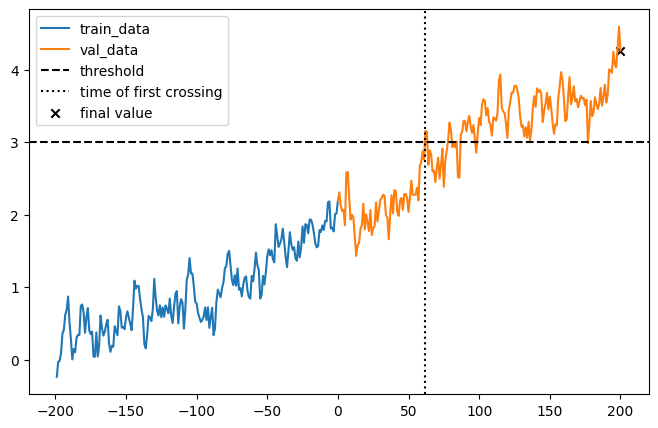

In [3]:
# Generate a trajectory
trajectory_length = 200
a = 0.01  # Slope
b = 0.0   # Intercept
sigma = 0.2  # Noise standard deviation
gamma = 0.8  # Autoregressive coefficient

train_data, val_data = get_trajectory(trajectory_length, a, b, sigma, gamma)
# True time of first crossing for validation data:
threshold = 3
if (val_data <= threshold).all():
    true_first_crossing_time = len(val_data)
else:
    true_first_crossing_time = np.argmax((val_data > threshold)).item()+1
print(f"time of first crossing threshold {threshold}: {true_first_crossing_time}")
# Get true future value:
future_time = len(val_data)-1
true_future_value = float(val_data[future_time])
print(f"True value at time {future_time}: {true_future_value}")

plt.figure(figsize = (8,5))
plt.plot(np.arange(-len(train_data)+1, 1), train_data, label="train_data")
plt.plot(np.arange(len(val_data)+1), np.hstack([train_data[-1:], val_data]), label="val_data")
plt.axhline(threshold, color="k", ls="--", label="threshold")
plt.axvline(true_first_crossing_time, color="k", ls=":", label="time of first crossing")
plt.scatter(len(val_data), val_data[-1], label="final value", marker="x", color="black")
plt.legend()
plt.show()

In [4]:
def evaluate_performance(predicted_first_crossing, predicted_final_value, true_first_crossing, true_final_value):
    # Compute the error of both:
    crossing_error = abs(predicted_first_crossing-true_first_crossing)
    final_error = abs(predicted_final_value-true_final_value)
    return {"crossing_error": crossing_error, "final_error": final_error}

def fit_and_evaluate_model(k, weight_decay, threshold, future_time, verbose=False):
    # Fit an AR(k) model with regularization
    ar_model = fit_autoregressive(train_data, k, weight_decay)
    
    # Sample future trajectories
    initial_seq = train_data[-k:]
    num_samples = 100
    forecast_horizon = len(val_data)
    samples = ar_model.sample(initial_seq, num_samples, forecast_horizon)
    
    # Predict time of first crossing
    crossing_time = ar_model.predict_time_of_first_crossing(initial_seq, num_samples, forecast_horizon, threshold)
    
    # Predict mean value at a future time
    mean_value = ar_model.predict_mean_value(initial_seq, future_time)
    if verbose:
        plt.plot(np.arange(-len(train_data)+1, 1), train_data, label="train_data")
        plt.plot(np.arange(len(val_data)+1), np.hstack([train_data[-1:], val_data]), label="val_data")
        plt.axhline(threshold, color="k", ls=":", label="threshold")
        plt.axvline(true_first_crossing_time, color="k", ls=":", label="time of first crossing")
        plt.scatter(len(val_data), val_data[-1], label="final value", marker="x", color="k")
        
        # Plot the samples:
        for i in range(5):
            plt.plot(np.arange(len(val_data)+1), np.hstack([train_data[-1:], samples[i]]), color="green", ls=":", lw=".2")
        
        plt.axvline(crossing_time, color="red", ls=":", label="predicted time of first crossing")
        plt.scatter(len(val_data), mean_value, label="predicted final value", marker="x", color="red")

        
        plt.legend()
        
        print(f"Expected time of first crossing threshold {threshold}: {crossing_time}")
        print(f"Predicted mean value at time {future_time}: {mean_value}")
    performance = evaluate_performance(
        predicted_first_crossing=crossing_time,
        predicted_final_value=mean_value,
        true_first_crossing=true_first_crossing_time,
        true_final_value=true_future_value
    )
    return {
        "predicted_crossing_time": crossing_time,
        "predicted_final_value": mean_value,
        **performance
    }


### Testing the model

Expected time of first crossing threshold 3: 162.87
Predicted mean value at time 199: 1.87545998537067


{'predicted_crossing_time': 162.87,
 'predicted_final_value': 1.87545998537067,
 'crossing_error': 100.87,
 'final_error': 2.3904274547779005}

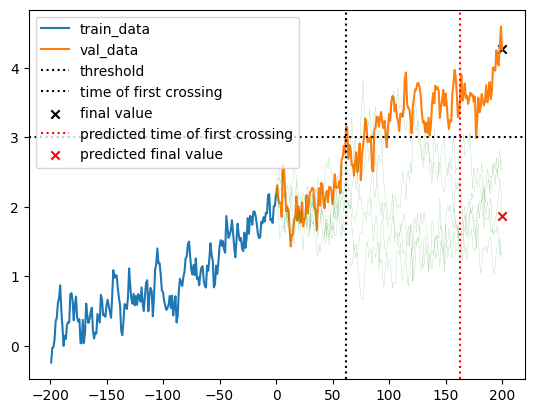

In [5]:
fit_and_evaluate_model(7,0.01, threshold, future_time, True)

,lag,weight_decay,predicted_crossing_time,predicted_final_value,crossing_error,final_error
0,9,0.057428,75.55,2.713289,13.55,1.552598
1,8,0.194728,112.00,2.149573,50.00,2.116314
2,9,0.262570,82.34,2.677531,20.34,1.588356
3,4,0.092049,197.21,-58.358374,135.21,62.624261
4,10,0.083692,84.78,-14.471968,22.78,18.737856
5,2,0.159218,194.64,1.166430,132.64,3.099457
6,19,0.572063,60.20,2.285242,1.80,1.980645
7,15,1.060199,91.30,2.425488,29.30,1.840399
8,12,0.339350,98.18,1.020597,36.18,3.245290
9,17,2.723468,109.84,2.359948,47.84,1.905939


<Axes: xlabel='crossing_error', ylabel='final_error'>

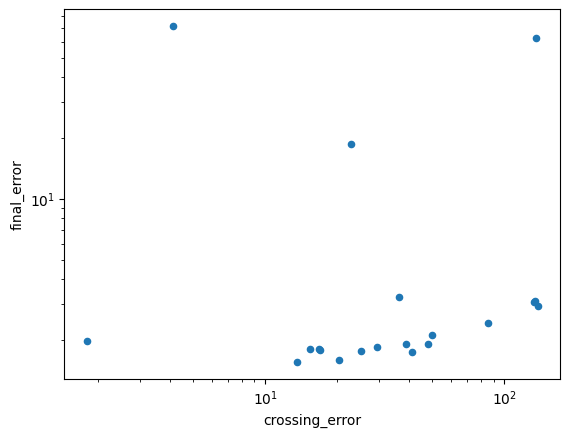

In [6]:
n_models = 20
ks = np.random.randint(20, size=n_models)
weight_decays = np.random.exponential(size=n_models)
results = []
for k, weight_decay in zip(ks, weight_decays):
    hparams = {"lag": k, "weight_decay": weight_decay}
    result = fit_and_evaluate_model(k, weight_decay, threshold, future_time, False)
    results.append({**hparams, **result})
performance_df = pd.DataFrame.from_records(results)
display(performance_df)
performance_df.plot.scatter(x="crossing_error", y="final_error", logy=True, logx=True)

## The Proposed Model: Rank-Based Bayesian Optimization (RBO)


###  RBO Procedure  

**Initialize:**  
Sample initial configurations $\{\mathbf{x}_1, \dots, \mathbf{x}_n\}$, evaluate the true function values $f(\mathbf{x}_i)$, rank them, and fit the worth model $\hat{S}(\mathbf{x})$.

**While** budget not exhausted:

1. **Select:**  
   Choose next query point  
   $\mathbf{x}^* = \arg\max_{\mathbf{x} \in \mathcal{X}} \hat{S}(\mathbf{x})$  

2. **Evaluate:**  
   Compute true error $f(\mathbf{x}^*)$

3. **Update:**  
   Re-rank the configurations, and refit the worth model $\hat{S}(\mathbf{x})$

4. **Predict:**  
   Update predictions $\hat{S}(\mathbf{x})$ for all $\mathbf{x} \in \mathcal{X}$  

**End While**


**Note:** predict_p serves as  $\hat{S}(\mathbf{x})$


In [7]:
import pandas as pd
import numpy as np
import torch

class RBO:
    def __init__(self, df, hyperparams, metrics, lr=0.01, max_iter=100, seed=42, verbose=False):
        self.df = df.copy()
        self.hyperparams = hyperparams
        self.metrics = metrics
        self.lr = lr
        self.max_iter = max_iter
        self.seed = seed
        self.verbose = verbose

        self.params = {}
        self.rank_df = None
        self.competition_matrix = None
        self.scaling_info = {}

    def normalize_hyperparams(self):
        """Normalize hyperparameter columns to [0, 1] range with max == min handling."""
        for col in self.hyperparams:
            min_val = self.df[col].min()
            max_val = self.df[col].max()
            if max_val == min_val:
                self.df[col] = 0.5  # set constant value
                self.scaling_info[col] = (min_val, max_val)
            else:
                self.df[col] = (self.df[col] - min_val) / (max_val - min_val)
                self.scaling_info[col] = (min_val, max_val)

    def compute_ranks(self):
        self.normalize_hyperparams()
    
        # Compute ranks for each metric
        for metric in self.metrics:
            self.df[f'Rank_{metric}'] = self.df[metric].rank(method='min').astype(int)
    
        # Compute max rank across all metrics for each model
        rank_cols = [f'Rank_{metric}' for metric in self.metrics]
        self.df['Max_Rank'] = self.df[rank_cols].max(axis=1)
    
        # Add model names
        self.df["Names"] = [f'Model_{i}' for i in range(len(self.df))]
    
        self.rank_df = self.df[self.hyperparams + ['Names'] + rank_cols + ['Max_Rank']].copy()
        return self.rank_df


    def build_competition_matrix(self):
        if self.rank_df is None:
            self.compute_ranks()
    
        models = self.rank_df['Names'].values
        max_ranks = self.rank_df['Max_Rank'].values
        n_models = len(models)
    
        comp_matrix = pd.DataFrame(
            data=np.zeros((n_models, n_models), dtype=int),
            index=models,
            columns=models
        )
    
        for i in range(n_models):
            for j in range(n_models):
                if i != j:
                    comp_matrix.iloc[i, j] = int(max_ranks[i] < max_ranks[j])
    
        self.competition_matrix = comp_matrix
        return self.competition_matrix


    def fit(self):
        torch.manual_seed(self.seed)
        self.n = len(self.df)

        self.compute_ranks()
        comp_matrix_df = self.build_competition_matrix()

        W = torch.tensor(comp_matrix_df.values, dtype=torch.float64)
        X = torch.tensor(self.rank_df[self.hyperparams].values, dtype=torch.float64)

        num_features = X.shape[1]
        linear_params = torch.randn(num_features, dtype=torch.float64, requires_grad=True)
        quad_params = torch.randn(num_features, dtype=torch.float64, requires_grad=True)
        intercept = torch.tensor(0.0, dtype=torch.float64, requires_grad=True)

        params = [linear_params, quad_params, intercept]
        optimizer = torch.optim.Adam(params, lr=self.lr)

        for iteration in range(self.max_iter):
            optimizer.zero_grad()
            p = torch.exp(torch.matmul(X, linear_params) + torch.matmul(X**2, quad_params) + intercept)

            log_likelihood = 0.0
            for i in range(self.n):
                for j in range(self.n):
                    if i != j:
                        log_likelihood += W[i, j] * (torch.log(p[i]) - torch.log(p[i] + p[j]))

            loss = -log_likelihood
            loss.backward()
            optimizer.step()

            if self.verbose and (iteration % 10 == 0 or iteration == self.max_iter - 1):
                print(f"Iteration {iteration+1}: Loss = {loss.item()}")

        self.params = {
            'linear': linear_params.detach().numpy(),
            'quadratic': quad_params.detach().numpy(),
            'intercept': intercept.item()
        }

    def normalize_new_values(self, new_values):
        """Normalize new hyperparameter values using fitted scaling info, with max == min handling."""
        if isinstance(new_values, pd.DataFrame):
            new_values = new_values.copy()
            for col in self.hyperparams:
                min_val, max_val = self.scaling_info[col]
                if max_val == min_val:
                    new_values[col] = 0.5
                else:
                    new_values[col] = (new_values[col] - min_val) / (max_val - min_val)
            return new_values[self.hyperparams].values
        elif isinstance(new_values, np.ndarray):
            normalized = []
            for i, col in enumerate(self.hyperparams):
                min_val, max_val = self.scaling_info[col]
                if max_val == min_val:
                    normalized_col = np.full(new_values.shape[0], 0.5)
                else:
                    normalized_col = (new_values[:, i] - min_val) / (max_val - min_val)
                normalized.append(normalized_col)
            return np.column_stack(normalized)
        else:
            raise ValueError("Input must be a pandas DataFrame or numpy array")

    def predict_p(self, hyperparam_values):
        if not self.params:
            raise ValueError("Model parameters not fitted yet. Call .fit() first.")

        X_new_normalized = self.normalize_new_values(hyperparam_values)
        X_new = torch.tensor(X_new_normalized, dtype=torch.float64)

        linear = torch.tensor(self.params['linear'], dtype=torch.float64)
        quadratic = torch.tensor(self.params['quadratic'], dtype=torch.float64)
        intercept = torch.tensor(self.params['intercept'], dtype=torch.float64)

        p = torch.exp(torch.matmul(X_new, linear) + torch.matmul(X_new**2, quadratic) + intercept)
        return p.detach().numpy()

    def get_model_details(self):
        if self.rank_df is None:
            self.compute_ranks()
        details_df = self.rank_df[['Names'] + self.hyperparams].copy()
        return details_df.set_index('Names')

    def get_params(self):
        return self.params

    def get_competition_matrix(self):
        if self.competition_matrix is None:
            self.build_competition_matrix()
        return self.competition_matrix.copy()

#### Using RBO on AR Task and Visualizing its steps

Trial 1/20...
Trial 2/20...
Trial 3/20...
Trial 4/20...
Trial 5/20...


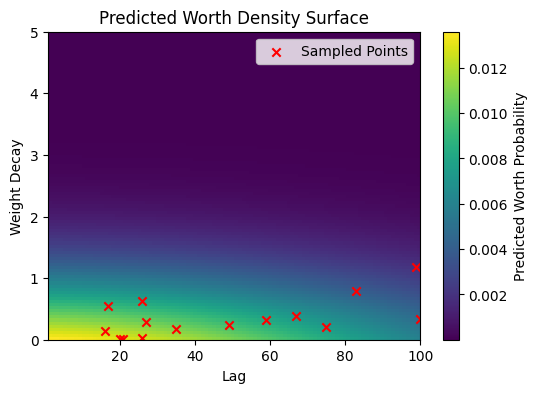

Trial 6/20...
Trial 7/20...
Trial 8/20...
Trial 9/20...
Trial 10/20...


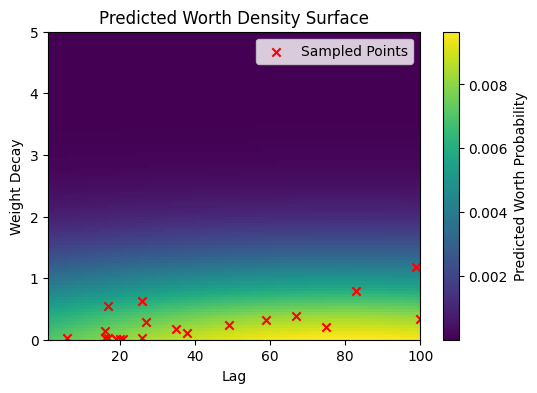

Trial 11/20...
Trial 12/20...
Trial 13/20...
Trial 14/20...
Trial 15/20...


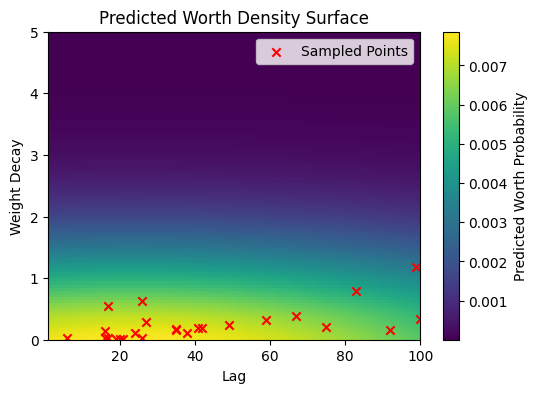

Trial 16/20...
Trial 17/20...
Trial 18/20...
Trial 19/20...
Trial 20/20...


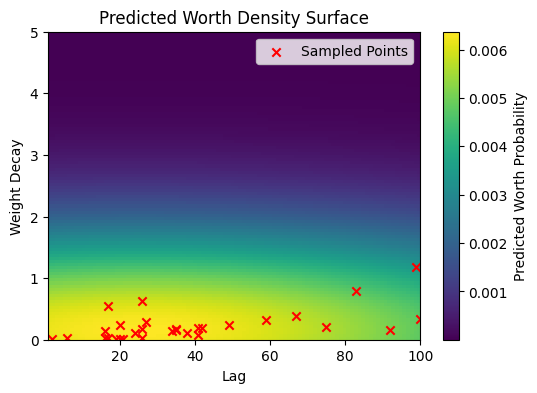

,lag,weight_decay,predicted_crossing_time,predicted_final_value,crossing_error,final_error,crossing_error_rank,final_error_rank,rank
0,20,0.233741,55.72,3.481854,6.28,0.784033,4.0,3.0,4.0
1,21,0.012858,60.91,5.523098,1.09,1.257211,1.0,8.0,8.0
2,35,0.175681,47.54,4.620765,14.46,0.354878,9.0,1.0,9.0
3,67,0.378124,69.38,2.708088,7.38,1.557800,6.0,10.0,10.0
4,34,0.146886,47.46,3.324629,14.54,0.941258,10.0,4.0,10.0



Time taken: 348.65 seconds


In [8]:
import time

def plot_2d_worth_estimator(worth_estimator, lag_space, weight_decay_space, past_data):
    """
    Plot the worth estimator's predicted probability surface in 2D.
    """
    # Create a grid of hyperparameter values
    X, Y = np.meshgrid(lag_space,  weight_decay_space)
    X_flat = X.ravel()
    Y_flat = Y.ravel()

    # Stack them into a tensor of shape (n_points, 2)
    X_ = np.column_stack([X_flat, Y_flat])

    # Get predicted worth probabilities
    p = worth_estimator.predict_p(X_).reshape(X.shape)

    # Normalize probabilities so they integrate to 1
    integral = p.sum() * (X.max() - X.min()) * (Y.max() - Y.min()) / (X.shape[0] * Y.shape[0])
    p /= integral

    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    plt.imshow(p, extent=[lag_space.min(), lag_space.max(), weight_decay_space.min(), weight_decay_space.max()],
               origin="lower", aspect="auto", cmap="viridis")
    plt.colorbar(label="Predicted Worth Probability")

    # Overlay past sampled points
    plt.scatter(past_data[:, 0], past_data[:, 1], color="red", marker="x", label="Sampled Points")
    plt.xlabel("Lag")
    plt.ylabel("Weight Decay")
    plt.title("Predicted Worth Density Surface")
    plt.legend()
    plt.show()

from scipy.stats import expon
np.random.seed(13)
lag_space = np.arange(1, 101) 
# Number of initial samples
n_initial_models = 10

# Exponential distribution scale for weight decay
wd_scale = 0.5

# Initial random sampling
initial_lags = np.random.choice(lag_space, n_initial_models)
initial_weight_decays = expon(scale=wd_scale).rvs(size=n_initial_models)

# Clip to desired range [0.01, 3]
max_weight_decay =  int(performance_df['weight_decay'].max())
initial_weight_decays = np.clip(initial_weight_decays, 0.01, max_weight_decay)
weight_decay_space = np.linspace(0, max_weight_decay, 100)
# Function to generate and evaluate models
def run_initial_models():
    results = []
    for k, weight_decay in zip(initial_lags, initial_weight_decays):
        hparams = {"lag": k, "weight_decay": weight_decay}
        result = fit_and_evaluate_model(k, weight_decay, threshold, future_time, verbose=False)
        results.append({**hparams, **result})
    
    performance_df = pd.DataFrame.from_records(results)
    return performance_df

# Fit and rank using the WorthEstimate class
def fit_and_rank_models(performance_df):
    worth_estimator = RBO(
        df=performance_df,
        hyperparams=["lag", "weight_decay"],
        metrics=["crossing_error", "final_error"],
        lr=0.01,
        max_iter=100,
        verbose=False
    )
    worth_estimator.fit()
    return worth_estimator

# Step 5: Select new hyperparameters based on the model's prediction of worth
def select_new_hyperparameters(worth_estimator, lag_space, weight_decay_space):
    n_candidates = 10
    new_lags = np.random.choice(lag_space, n_candidates).astype(int)
    #new_weight_decays = np.random.choice(weight_decay_space, n_candidates)
    # Sample candidates from the same exponential distribution
    new_weight_decays = expon(scale=wd_scale).rvs(size=n_candidates)
    new_weight_decays = np.clip(new_weight_decays, 0.01, 3)


    new_hparams = np.column_stack([new_lags, new_weight_decays])
    predicted_worths = worth_estimator.predict_p(new_hparams)

    best_index = np.argmax(predicted_worths)
    best_lag = int(new_hparams[best_index, 0])
    best_weight_decay = new_hparams[best_index, 1]

    return best_lag, best_weight_decay



def iterative_model_selection(max_trials=10):
    # Start with initial models and evaluate
    performance_df = run_initial_models()
    worth_estimator = fit_and_rank_models(performance_df)
    
    trial = 0
    while trial < max_trials:
        trial += 1
        print(f"Trial {trial}/{max_trials}...")
        
        # Select new hyperparameters based on predicted worth
        best_lag, best_weight_decay = select_new_hyperparameters(worth_estimator, lag_space, weight_decay_space)
        
        # Evaluate the new model
        result = fit_and_evaluate_model(best_lag, best_weight_decay, threshold, future_time, verbose=False)
        new_result = {"lag": best_lag, "weight_decay": best_weight_decay, **result}

        # Add the new model's results to the performance dataframe
        performance_df = pd.concat([performance_df, pd.DataFrame([new_result])], ignore_index=True)
        
        # Re-fit and re-rank the models
        worth_estimator = fit_and_rank_models(performance_df)
        
        # visualize progress (like the scatter plot of errors)
        if trial % 5 == 0 or trial == max_trials:
            past_data = performance_df[[ "lag", "weight_decay"]].to_numpy()
            plot_2d_worth_estimator(worth_estimator, lag_space, weight_decay_space, past_data)

    
    # Compute ranks for both metrics (lower error is better)
    performance_df["crossing_error_rank"] = performance_df["crossing_error"].rank(method="min", ascending=True)
    performance_df["final_error_rank"] = performance_df["final_error"].rank(method="min", ascending=True)

    # Take max rank for each model
    performance_df["rank"] = performance_df[["crossing_error_rank", "final_error_rank"]].max(axis=1)

    # Sort by the overall rank
    performance_df = performance_df.sort_values("rank").reset_index(drop=True)

    # Return the top 5 models based on this rank
    top_5_df = performance_df.head(5)

    return top_5_df, performance_df  # if you still want access to full results

# Start timer
start_time = time.time()

# Run the iterative model selection process
top_5_performers, final_performance_df = iterative_model_selection(max_trials=20)

# End timer
end_time = time.time()

# Display results and timing
display(top_5_performers)
print(f"\nTime taken: {end_time - start_time:.2f} seconds")


Predicted Worth Density Surface Heatmap depicting how the Worth function $S$ balances exploration and exploitation of areas with low and high probability of high values. The darker places imply low probability, and the heat area means places where $S$ is expected to be high. The sample points x
 are the evaluated hyperparameter configurations (weight decay and lag). The final set of iterations shows that more evaluated points are from the high area of $S$.

Expected time of first crossing threshold 3: 55.44
Predicted mean value at time 199: 3.481856442244846


{'predicted_crossing_time': 55.44,
 'predicted_final_value': 3.481856442244846,
 'crossing_error': 6.560000000000002,
 'final_error': 0.7840309979037241}

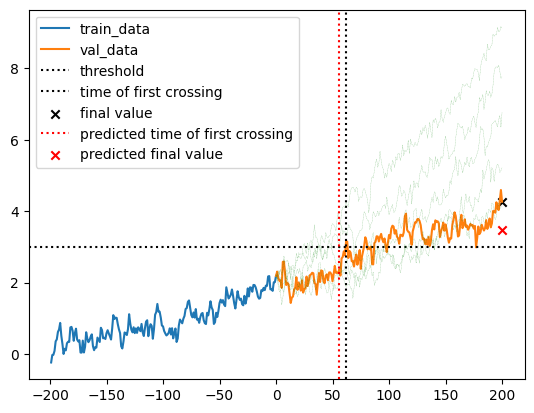

In [9]:
#testing the model
fit_and_evaluate_model(20,	0.233741, threshold, future_time, True)

Prediction of crossing and final value for RBO method, alongside data information. Blue and red trajectories represent the training and validation data, respectively. The black and red vertical lines indicate the true and predicted crossing times, while the black and red mark 'x' denotes the true and predicted final values. The faded green trajectories are the Monte Carlo samples of the validation data. The horizontal axis value was used in place of time, with $-200$ to $0$ as the past data (training) and $1$ to $200$ as future time (validation). Our RBO achieved the best performance on final value prediction and a reasonably good result on crossing time.

## Using Optuna

For Optuna, we define the objective function that takes in the hyperparameter space as the trial, and the AR model function, which allows it to evaluate the function when necessary. The process is treated as a single objective with the two error values added and optimized together.

Best params: {'lag': 20, 'weight_decay': 1.4158282450531063}
Best value (total error): 3.238038380353544

Optimization time: 1.64 seconds
Expected time of first crossing threshold 3: 59.17
Predicted mean value at time 199: 2.6478490597950235

Performance at best parameters: {'predicted_crossing_time': 59.17, 'predicted_final_value': 2.6478490597950235, 'crossing_error': 2.8299999999999983, 'final_error': 1.6180383803535467}
Evaluation time: 0.09 seconds


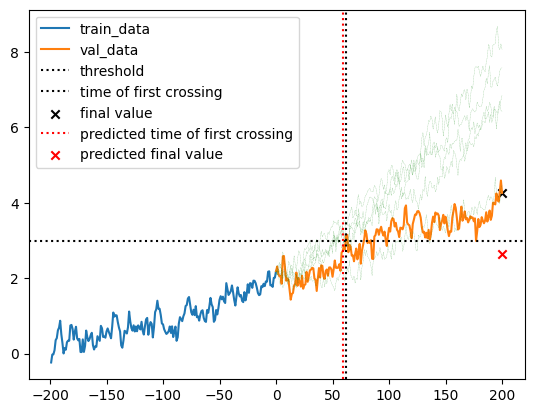

In [10]:
import time
import optuna

# Silence Optuna logs
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Fix Optuna's sampler seed for reproducibility
sampler = optuna.samplers.TPESampler(seed=13)

# Create study with the seeded sampler
study = optuna.create_study(direction='minimize', sampler=sampler)

def objective(trial):
    # Seed NumPy and random for reproducibility in this trial
    seed = 3 + trial.number  # making each trial deterministic, but reproducible across runs
    np.random.seed(seed)
    random.seed(seed)

    # Suggest hyperparameters
    lag = trial.suggest_int('lag', 1, 50)
    weight_decay = trial.suggest_float('weight_decay', 1e-3, 2.0)

    # Evaluate model with suggested params
    result = fit_and_evaluate_model(
        k=lag, 
        weight_decay=weight_decay,
        threshold=threshold, 
        future_time=future_time, 
        verbose=False
    )

    return result["crossing_error"] + result["final_error"]

# Start timer for optimization
opt_start_time = time.time()

# Run optimization
study.optimize(objective, n_trials=30)

# End timer
opt_end_time = time.time()

# Report results
print("Best params:", study.best_params)
print("Best value (total error):", study.best_value)
print(f"\nOptimization time: {opt_end_time - opt_start_time:.2f} seconds")

# Start timer for final evaluation
eval_start_time = time.time()

# Evaluate at best params
best_result = fit_and_evaluate_model(
    k=study.best_params["lag"],
    weight_decay=study.best_params["weight_decay"],
    threshold=threshold,
    future_time=future_time,
    verbose=True
)

# End timer
eval_end_time = time.time()

print("\nPerformance at best parameters:", best_result)
print(f"Evaluation time: {eval_end_time - eval_start_time:.2f} seconds")


## Rank-Based Random Search

In [34]:
import time

def rank_based_random_search(n_trials=30):
    np.random.seed(13)
    random.seed(13)
    results = []

    start_time = time.time()

    for i in range(n_trials):
        lag = np.random.randint(1, 51)
        weight_decay = np.random.uniform(1e-3, 2.0)

        result = fit_and_evaluate_model(
            k=lag,
            weight_decay=weight_decay,
            threshold=threshold,
            future_time=future_time,
            verbose=False
        )

        results.append({
            "lag": lag,
            "weight_decay": weight_decay,
            "crossing_error": result["crossing_error"],
            "final_error": result["final_error"]
        })

    end_time = time.time()
    total_time = end_time - start_time

    results_df = pd.DataFrame(results)
    results_df = results_df.astype({'lag': 'int'})


    # Rank for each metric — lower error gets better rank (1 is best)
    results_df["rank_crossing"] = results_df["crossing_error"].rank(method="min", ascending=True)
    results_df["rank_final"] = results_df["final_error"].rank(method="min", ascending=True)

    # Max-rank aggregation: take the worse (higher) of the two ranks for each config
    results_df["max_rank"] = results_df[["rank_crossing", "rank_final"]].max(axis=1)

    # Get the config with the best (lowest) max-rank
    best_row = results_df.loc[results_df["max_rank"] == results_df["max_rank"].min()].iloc[0]
    best_params = {
    "lag": int(best_row["lag"]),   # <-- fix here
    "weight_decay": best_row["weight_decay"]
    }

    best_params = {
        "lag": best_row["lag"],
        "weight_decay": best_row["weight_decay"]
    }

    return best_params, total_time, results_df

# Run rank-based random search
best_params_rank, time_taken_rank, rank_results_df = rank_based_random_search(n_trials=30)

print("\nRank-Based Random Search (Max-Rank Aggregation) Results")
print("--------------------------------------------------------")
print("Best params:", best_params_rank)
print(f"Search time: {time_taken_rank:.2f} seconds")


Rank-Based Random Search (Max-Rank Aggregation) Results
--------------------------------------------------------
Best params: {'lag': np.float64(48.0), 'weight_decay': np.float64(0.401953475978537)}
Search time: 0.51 seconds


Expected time of first crossing threshold 3: 55.64
Predicted mean value at time 199: 3.24389489046652
Performance at best parameters (Rank-Based Random Search): {'predicted_crossing_time': 55.64, 'predicted_final_value': 3.24389489046652, 'crossing_error': 6.359999999999999, 'final_error': 1.02199254968205}
Evaluation time: 0.03 seconds


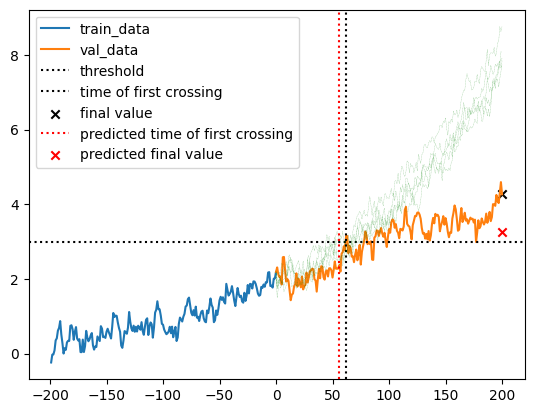

In [35]:
# Evaluate at best params
start_eval_rank = time.time()
best_result_rank = fit_and_evaluate_model(
    k=int(best_params_rank["lag"]),
    weight_decay=best_params_rank["weight_decay"],
    threshold=threshold,
    future_time=future_time,
    verbose=True
)
end_eval_rank = time.time()

print("Performance at best parameters (Rank-Based Random Search):", best_result_rank)
print(f"Evaluation time: {end_eval_rank - start_eval_rank:.2f} seconds")


The random search was treated in the same way as our proposed model to ensure a fair comparison. Unlike Optuna, which has access to the absolute value, the random search approach was based on rank as well. $30$ number of trials were randomly selected from the hyperparameter space and were evaluated on the AR model, after which the max-rank approach was used to select the best configurations according to the rank-based random search outcome. Its best performing configurations are $48$ and $0.4019$ for lag and weight decay, respectively. This gives $6.36$ and $1.02$ crossing and final error values. 
